# HW03
Deep Learning, GIST RT5101-01, 2024, Spring, (Tue/Thurs 2:30~3:45)
***

### Problem1. Build cat and dog detection dataset code
(Download URL: https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection)
- Build detection dataset code
- Check your dataset code
----

### Problem2. Train cat and dog detection data using FasterRCNN
- Training detection dataset
- Check the result
- Analysis your result

***
### You can add additional code for checking your image and model.
### You must summit ``.ipynb`` file. Do not summit ``.py`` file.
---

### How to submit your homework
Submit your jupyter notebook file with the filename of  *HW03_studentnumber.ipynb*  on GIST LMS

Ex) HW03_20222015.ipynb  

### Submission deadline
2024.06.16, Sunday 23:59 (PM)

### Plagiarism
We encourage you to discuss this homework with your friends or TA, but you should write your own code.




***
***

In [ ]:
# mount your google drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Problem 1. (total 5 pt.)
**Build cat and dog detection dataset code**

- **1**. Build dataset code
- **2**. Split into train dataset and test dataset.
- **3**. Check your dataset code

### Problem 1-1. (2 pt.)
Build dataset code

In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to read annotation files
def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        width = int(data.find("width").text)
        height = int(data.find("height").text)
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax, width, height])
    return records

In [2]:
class CatDogDataset(Dataset):
    def __init__(self, root, annotations, transforms=None, shape=(256, 256)):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations = annotations
        self.shape = shape

    def __len__(self):
        return len(self.imgs)

    def _preprocess_image(self, img, bboxes):
        h, w, _ = img.shape
        img = cv2.resize(img, self.shape)  # 리사이즈
        H, W, _ = img.shape  # 리사이즈 후의 크기
        scale_x, scale_y = W / w, H / h  # 스케일링 비율 계산

        scaled_bboxes = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            x1, x2 = x1 * scale_x, x2 * scale_x
            y1, y2 = y1 * scale_y, y2 * scale_y
            scaled_bboxes.append([x1, y1, x2, y2])

        return img, scaled_bboxes

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        
        filename = self.imgs[idx]
        annots = [annot for annot in self.annotations if annot[0] == filename]

        boxes = []
        labels = []
        for annot in annots:
            xmin = annot[2]
            ymin = annot[3]
            xmax = annot[4]
            ymax = annot[5]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class (e.g., 1 for cat/dog)

        if len(boxes) > 0:
            img, boxes = self._preprocess_image(img, boxes)

        img = (img / 255.).astype(np.float32)
        
        if self.transforms:
            img = Image.fromarray((img * 255).astype(np.uint8))  # To PIL Image
            img = self.transforms(img)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

### Problem 1-2. (2 pt.)
Split into train dataset and test dataset.


In [3]:
batch_size = 8

In [4]:
import sys
### Change to your own path
sys.path.append('')


In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))
# used for padding variable-length batches.
# "*" = splat operator : unpacking a list into arguments

In [6]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    return T.Compose(transforms)

In [7]:
annotations = read_ann('./data/annotations')
dataset = CatDogDataset('./data', annotations, transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

dataset_test = CatDogDataset('./data', annotations, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [8]:
# Check dataset loader's return
for i, (img, target) in enumerate(data_loader):
  for j in range(len(img)):
    print('Size of image : (C, H, W) ',img[j].shape)
    print('Number of the objects :', len(target[j]['boxes']))
  if i> 3:
    break

Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])
Number of the objects : 1
Size of image : (C, H, W)  torch.Size([3, 256, 256])

### Problem 1-3. (1 pt.)
Check your dataset code

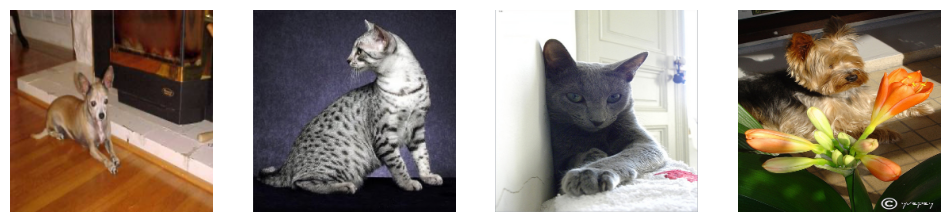

In [9]:
# visualize train image
def visualize_train_image(loader, batch_size, num_batches=1, num_images_per_batch=2):
    for i, (imgs, targets) in enumerate(loader):
        fig, axs = plt.subplots(1, num_images_per_batch, figsize=(num_images_per_batch*3, 3))
        for j in range(num_images_per_batch):
            img = imgs[j].permute(1, 2, 0).numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[j].imshow(img)
            axs[j].axis('off')
        plt.show()
        if i >= num_batches - 1:
            break

# Visualize some data
visualize_train_image(data_loader, batch_size=4, num_batches=1, num_images_per_batch=4)

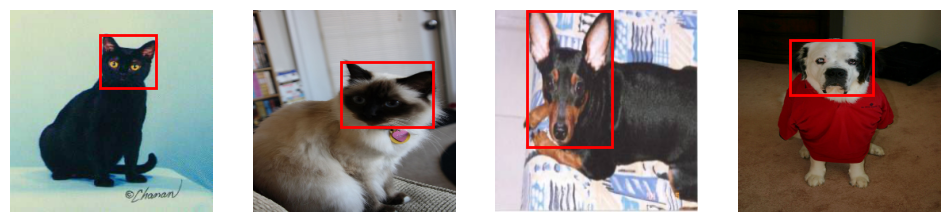

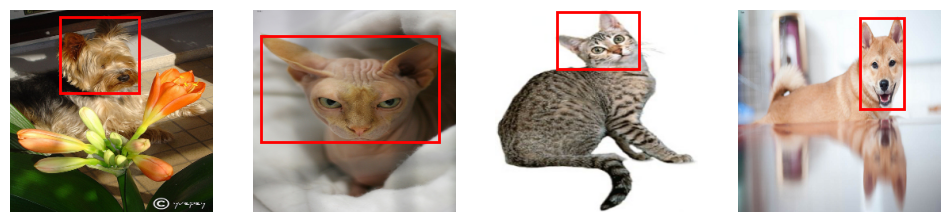

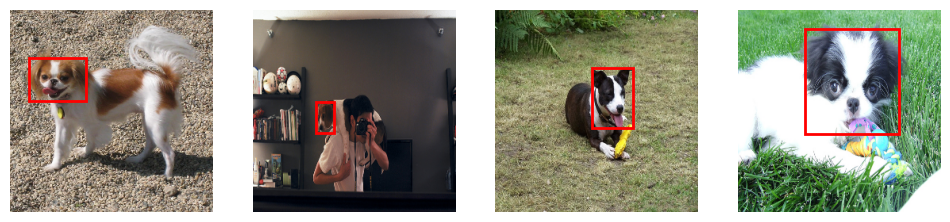

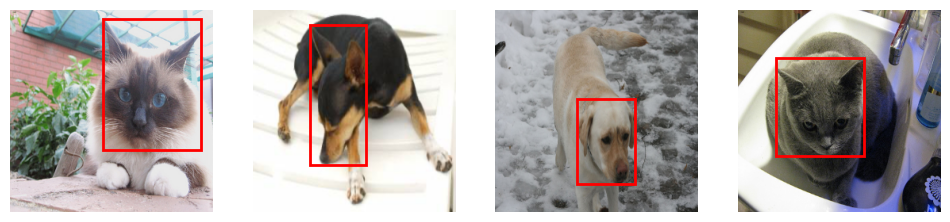

In [10]:
# visualize train image's bbox
def visualize_data_bbox(loader, batch_size, num_batches=1, num_images_per_batch=2):
    for i, (imgs, targets) in enumerate(loader):
        fig, axs = plt.subplots(1, num_images_per_batch, figsize=(num_images_per_batch*3, 3))
        for j in range(num_images_per_batch):
            img = imgs[j].permute(1, 2, 0).numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[j].imshow(img)
            for box in targets[j]['boxes']:
                rect = patches.Rectangle(
                    (box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                axs[j].add_patch(rect)
            axs[j].axis('off')
        plt.show()
        if i >= num_batches - 1:
            break

# Visualize some data
visualize_data_bbox(data_loader, batch_size=4, num_batches=4, num_images_per_batch=4)

---
---

## Problem 2. (Total 5 pt.)
- **Train Dogs and Cats data using FasterRCNN**


### Problem 2-1. (3 pt.)
- **Step 1**. Import package.
- **Step 2**. Build your FasterRCNN model.
- **Step 3**. Define hyper-parameter for training
- **Step 4**. Train the model and check the validation results  

In [20]:
''' Step 1 '''
# Import package.
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from bs4 import BeautifulSoup
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import mobilenet_v2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [12]:
import sys
### Change to your own path
# sys.path.append('/content/drive/MyDrive/2024_deep_learning/coding_lecture/04.04.CodingLecture05/vis_utils')

import utils
from engine import *
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

In [13]:
''' Step 2 '''
# Build your FasterRCNN model.

def get_model(num_classes):
    # pretrained=True로 미리 학습된 ResNet-50 기반 Faster R-CNN 모델 로드
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # 클래스 분류기를 새로운 클래스 수에 맞게 변경
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

# GPU가 사용 가능한지 확인
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 모델 초기화
num_classes = 2  # 배경 + 1 클래스
model = get_model(num_classes)
model.to(device)

c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
''' Step 3 '''
# Define hyper-parameter for training.

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
batch_size=8

In [15]:
''' Step 4 '''
# Train the model and check the validation results

' Step 4 '

In [16]:
# define model training function

# engine.py에 있는 train_one_epoch 함수를 사용하기로 한다.

In [17]:
# model training
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()

c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: [0]  [  0/922]  eta: 1:01:56  lr: 0.000010  loss: 1.0613 (1.0613)  loss_classifier: 0.8874 (0.8874)  loss_box_reg: 0.1494 (0.1494)  loss_objectness: 0.0139 (0.0139)  loss_rpn_box_reg: 0.0105 (0.0105)  time: 4.0305  data: 0.0359  max mem: 3017
Epoch: [0]  [ 10/922]  eta: 0:29:55  lr: 0.000065  loss: 0.8904 (0.8464)  loss_classifier: 0.7142 (0.6934)  loss_box_reg: 0.1377 (0.1258)  loss_objectness: 0.0157 (0.0225)  loss_rpn_box_reg: 0.0036 (0.0047)  time: 1.9683  data: 0.0312  max mem: 3176
Epoch: [0]  [ 20/922]  eta: 0:27:56  lr: 0.000119  loss: 0.4768 (0.6057)  loss_classifier: 0.2932 (0.4476)  loss_box_reg: 0.1377 (0.1323)  loss_objectness: 0.0189 (0.0199)  loss_rpn_box_reg: 0.0051 (0.0060)  time: 1.7498  data: 0.0310  max mem: 3176
Epoch: [0]  [ 30/922]  eta: 0:27:19  lr: 0.000173  loss: 0.3073 (0.5003)  loss_classifier: 0.1354 (0.3418)  loss_box_reg: 0.1386 (0.1332)  loss_objectness: 0.0139 (0.0193)  loss_rpn_box_reg: 0.0066 (0.0060)  time: 1.7663  data: 0.0336  max mem: 3177


In [18]:
torch.save(model.state_dict(), "fasterrcnn_resnet50_fpn.pth")

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 배경 포함 클래스 수
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 모델 불러오기
state_dict = torch.load("fasterrcnn_resnet50_fpn.pth")
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [22]:
# define model evaluate function

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    """
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    xi1 = max(x1, x1_)
    yi1 = max(y1, y1_)
    xi2 = min(x2, x2_)
    yi2 = min(y2, y2_)

    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_ - x1_ + 1) * (y2_ - y1_ + 1)

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area

    return iou

def evaluate_model(loader, model, device, iou_threshold=0.5):
    model.eval()
    total_iou = 0
    total_images = 0
    num_correct = 0
    num_total = 0
    
    for images, targets in loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images)
        
        for i in range(len(images)):
            pred_boxes = outputs[i]['boxes'].cpu().numpy()
            true_boxes = targets[i]['boxes'].cpu().numpy()

            for pred_box in pred_boxes:
                for true_box in true_boxes:
                    iou = calculate_iou(pred_box, true_box)
                    total_iou += iou
                    num_total += 1
                    if iou >= iou_threshold:
                        num_correct += 1

            total_images += 1

    mean_iou = total_iou / num_total
    accuracy = num_correct / num_total

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
# run evaluate code
evaluate_model(data_loader_test, model, device)

KeyboardInterrupt: 

### Problem 2-2. (2 pt.)
Analysis your result

In [ ]:
import cv2
def overlay_instances(img, prediction, threshold=0.8):
    label_dict = {0: 'cat', 1: 'dog'}
    ori_img = img.mul(255).permute(1,2,0).byte().numpy() # Tensor * 255, Convert RGB -> BGR, Tensor to numpy
    for idx in range(len(prediction[0]['boxes'])):
        score = prediction[0]['scores'][idx].cpu().detach().numpy().item() # detach() : Generation of tensors that do not propagate gradients from existing sensors
        if score < threshold:
            continue
        box = x1,y1,x2,y2 = prediction[0]['boxes'][idx].cpu().detach().numpy()
        label = prediction[0]['labels'][idx].cpu().detach().numpy().item()
        print(x1,y1, x2, y2)
        cv2.rectangle(ori_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
        cv2.rectangle(ori_img, (int(x1), int(y1)), (int(x1+60), int(y1+20)), (255,0,0),-1)
        cv2.putText(ori_img, label_dict[label], (int(x1), int(y1+15)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), thickness=1)
    return Image.fromarray(ori_img)

In [ ]:
# Inference on test images
for images, targets in data_loader_test:
    images = list(img.to(device) for img in images)
    with torch.no_grad():
        outputs = model(images)

    for image, target, output in zip(images, targets, outputs):
        # 예측 결과 시각화
        vis_image = overlay_instances(image, [output], threshold=0.5)
        vis_image.show()

    break  # 첫 번째 배치만 시각화

#### Your Anwser :

In [ ]:
def visualize_predictions(image, predictions, threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, score, label in zip(predictions['boxes'].cpu(), predictions['scores'].cpu(), predictions['labels'].cpu()):
        if score >= threshold:
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1

            # 바운딩 박스 그리기
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)

            # 레이블 그리기
            label_text = 'face' if label == 1 else 'unknown'
            ax.text(x1, y1, label_text, bbox=dict(facecolor='blue', alpha=0.5), fontsize=12, color='white')

    plt.axis('off')
    plt.show()

# 데이터 로더를 사용하여 예측 및 시각화
for images, targets in data_loader_test:
    images = list(img.to(device) for img in images)
    with torch.no_grad():
        outputs = model(images)

    for image, target, output in zip(images, targets, outputs):
        # 이미지 텐서를 PIL 이미지로 변환
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * 255).astype(np.uint8)
        image = Image.fromarray(image)

        # 예측 결과 시각화
        visualize_predictions(image, output)

    break  # 첫 번째 배치만 시각화